In this notebook I am using the concept of a kernel filter used in CNN's and neural automatons to create an edge detection feature map. For far less complexity the 512x512 image with 4 color attribute's per pixel is converted to grey-scale. This works much more optimally as we are interessted in the position of the edges and if need be the edge features can be mapped onto the color image.

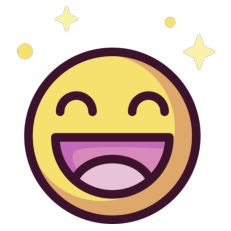

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Reading in the image and displaying it
img = mpimg.imread("smiley.png")
plt.imshow(img)
plt.axis('off')
plt.show()

In [2]:
#Creating an image matrix to store the converted grey scale image
image_matrix = np.zeros((512, 512), dtype=np.float32)

#img = mpimg.imread("smiley.png")
#Iterating through the image and adding the color contributions
for indi, i in enumerate(img):
    for indj, j in enumerate(i):
        R, G, B, I = j
        grey_val = 0.33 * R + 0.33 * G + 0.34 * B
        #Getting a value between 0 and 255
        grey_val = int(grey_val * 255)
        image_matrix[indi][indj] = grey_val

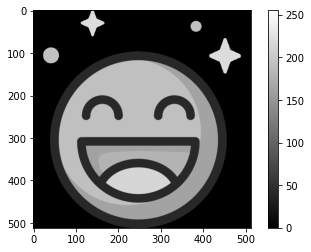

In [3]:
#Plotting the greyscale image
plt.imshow(image_matrix, cmap='gray', vmin=0, vmax=255)
plt.colorbar()
plt.show()

We now need to create a padding layer around the image so that when we use the kernel the edge rows and columns are not lost. Because there are some features near the edges I am creating a 50 layer padding

In [4]:
#for padding we first need to add 50 rows of 0 to top and bottom of matrix
row_padding = np.zeros((50,512))
padded_matrix = np.vstack((row_padding, image_matrix))
padded_matrix = np.vstack((padded_matrix, row_padding))

#Now the horizontal, note the rows have also increased because of the row_padding
col_padding = np.zeros((612,50))
padded_matrix = np.hstack((col_padding, padded_matrix))
padded_matrix = np.hstack((padded_matrix, col_padding))

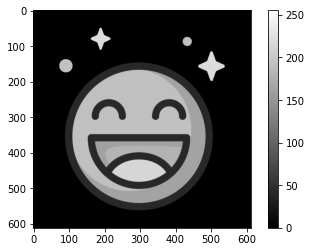

In [5]:
plt.imshow(padded_matrix, cmap='gray', vmin=0, vmax=255)
plt.colorbar()
plt.show()

## Creating the kernel

We will use the following kernel structure vertical edge matrix => [[1,0,-1], [2, 0, -2], [1, 0, -1]] and horizontal edge matrix => [[1, 2, 1], [0, 0, 0], [-1, -2, -1]]. This structure is used as it gives equal and opposite weightings to different sides of the kernel, so when the kernel is traversing an edge(a region that goes from dark to light or light to dark) there will be an effect. For the kernel to work we just need to take the dot product of the kernel matrix and the 9x9 sub-image-grids and then traverse

In [6]:
vertical_edge_matrix = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
horizontal_edge_matrix = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

In [7]:
vertical_edge = np.zeros((611, 611), dtype=np.float32)
for x in range(1,612):
    for y in range(1, 612):
        starty = int(y/3)*3;
        startx = int(x/3)*3;
        subgrid = padded_matrix[starty:starty+3, startx:startx+3]
        vertical_edge[y-1][x-1] = np.sum(subgrid * vertical_edge_matrix)

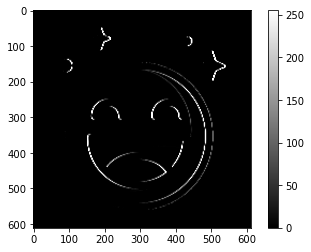

In [8]:
plt.imshow(vertical_edge, cmap='gray', vmin=0, vmax=255)
plt.colorbar()
plt.show()

In [9]:
horizontal_edge = np.zeros((611, 611), dtype=np.float32)
for x in range(1,612):
    for y in range(1, 612):
        starty = int(y/3)*3;
        startx = int(x/3)*3;
        subgrid = padded_matrix[starty:starty+3, startx:startx+3]
        horizontal_edge[y-1][x-1] = np.sum(subgrid * horizontal_edge_matrix)

In [10]:
#Filtering out all the white values that didn't get removed
#horizontal_edge[horizontal_edge<240]=0

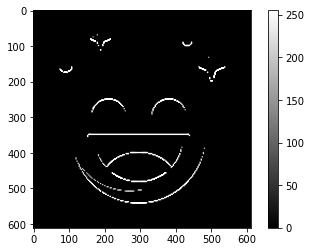

In [11]:
plt.imshow(horizontal_edge, cmap='gray', vmin=0, vmax=255)
plt.colorbar()
plt.show()

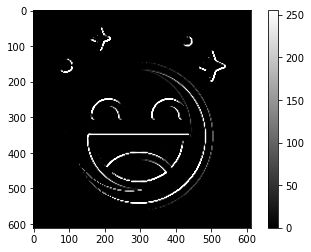

In [12]:
plt.imshow(horizontal_edge + vertical_edge, cmap='gray', vmin=0, vmax=255)
plt.colorbar()
plt.show()

The final output does detect edges relatively well, however upon inspection it seems as though it has a right handed bias to edge detection. This may be as a result of the kernel traversing right and it's direction. We can also further improve the edge detection by attempting some diagonal traversals or other movements/kernels.

## Creating a kernel operation function

In [67]:
def kernel_convolution(kernel):
    output = np.zeros((611, 611), dtype=np.float32)
    for x in range(1,612):
        for y in range(1, 612):
            starty = int(y/3)*3;
            startx = int(x/3)*3;
            subgrid = padded_matrix[starty:starty+3, startx:startx+3]
            output[y-1][x-1] = np.sum(subgrid * kernel)
    output[output < 0] = 0 
    return output

def plotter(grid):
    plt.imshow(grid, cmap='gray', vmin=0, vmax=255)
    plt.colorbar()
    plt.show()

---

In [68]:
vertical_kernel_r = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
horizontal_kernel_r = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
vertical_kernel_l = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
horizontal_kernel_l = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
diagonal_kernel_r = np.array([[1, 2, 0], [2, 0, -2], [0, -2, -1]])
diagonal_kernel_l = np.array([[-1, -2, 0], [-2, 0, 2], [0, 2, 1]])
inverse_diagonal_r = np.array([[0 ,2, 1], [2, 0, -2], [-1, -2, 0]])
inverse_diagonal_l = np.array([[0 ,-2, -1], [-2, 0, 2], [1, 2, 0]])

In [69]:
kernels = [vertical_kernel_r, vertical_kernel_l, horizontal_kernel_r, horizontal_kernel_l, diagonal_kernel_r, diagonal_kernel_l, inverse_diagonal_r, inverse_diagonal_l]

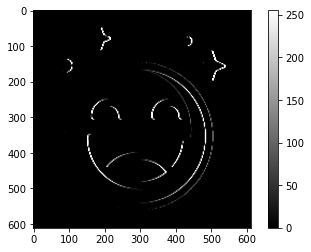

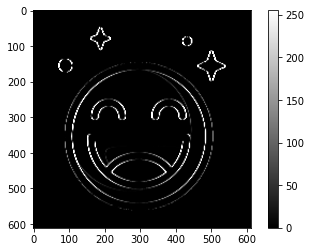

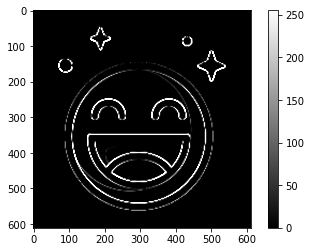

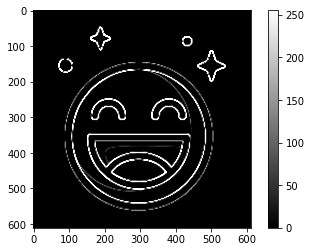

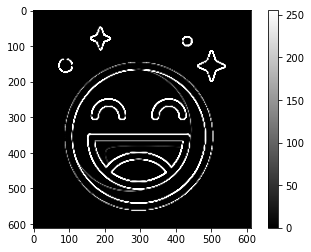

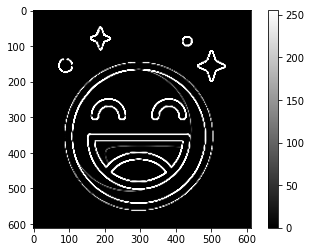

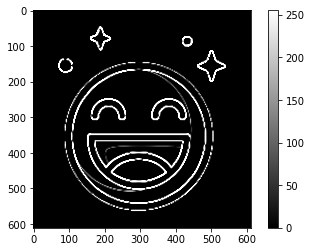

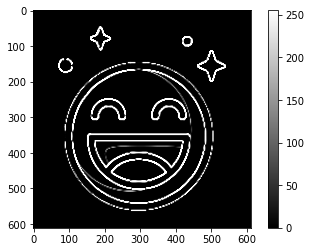

In [70]:
#We can now apply the kernels in superposition
init_grid = np.zeros((611, 611))
for i in kernels:
    #plotter(kernel_convolution(i))
    init_grid = init_grid + kernel_convolution(i)
    plotter(init_grid)

---

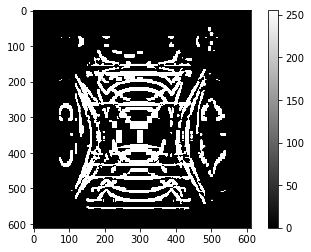

In [13]:
plt.imshow(np.dot(vertical_edge, horizontal_edge), cmap='gray', vmin=0, vmax=255)
plt.colorbar()
plt.show()